In [73]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import boxcox
import statsmodels.api as sm

In [17]:
def read_pickle(path):
    
    input_file = open(path,'rb')
    variable = pickle.load(input_file)
    input_file.close()
    return(variable)

In [18]:
# Read in data
data = read_pickle('../data/watch/processed_data/train_df.pkl')

In [23]:
data.columns

Index(['subject_id', 'activity_class', 'timestamp', 'accel_x', 'accel_y',
       'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'is_exercise', 'time_period'],
      dtype='object')

In [7]:
# Split features and target
x_train = data.drop('is_exercise', axis = 1)
y_train = data['is_exercise']

## Time-Series EDA

In [105]:
def multi_scatter_plot(data, x_variables, y_variable, subject_id):
    ''' For a specific subject, plot their xyz scatterplots, colour coded
        for exercise/non-exercise label'''
    
    for i in x_variables:
        sns.lmplot(x='time_period', y=i, data=data[data['subject_id']==subject_id],
                   fit_reg=False, hue=y_variable, legend=False, height=4, aspect=2.5)
        
    return None

def pacf_plots(data, x_variables, y_variable, subject_id, downsample_steps=10):
    ''' For a specific subject, plot thier xyz pacf'''
    
    df = data.copy(deep=True)
    
    # Downsample
    df = df[df['subject_id'] == subject_id]
    df['downsample'] = df['time_period'] % downsample_steps
    df = df[df['downsample'] == 0]
    
    # Plot pacfs for each variables
    for i in x_variables:
        series = sm.graphics.tsa.plot_pacf(df[i], zero = False)
    
    return None

def basic_time_series_transformations(data, x_variables, y_variable, boxcox=True, differening=True):
    ''' For each time-dependent variable, perform the basic box-cox and first difference transformation'''
    
    df = data.copy(deep=True)
    
    # Perform transformations
    for i in x_variables:
        
        # Box-Cox estimation
        df[i] = df[i] - min(df[i]) + 0.0001
        y, fitted_lambda = boxcox(df[i],lmbda = None)
        
        # First difference, make first element nan, loss from differencing
        y = np.append([np.nan], np.diff(y, n=1))
        df[i + '_transformed'] = y
    
    return(df)

In [67]:
subject_ids = list(set(data['subject_id']))
random.shuffle(subject_ids)
subject_ids[0]

1604

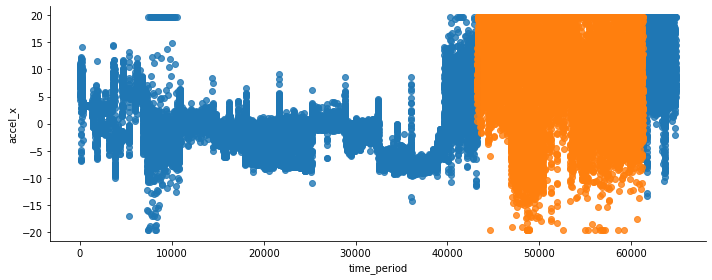

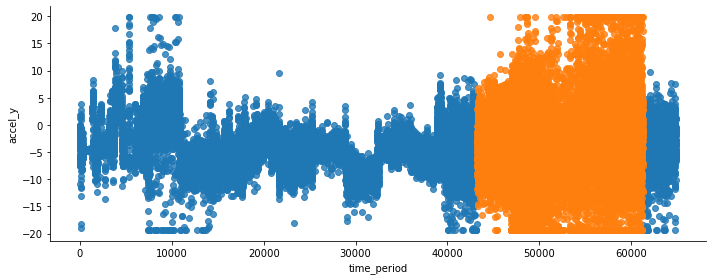

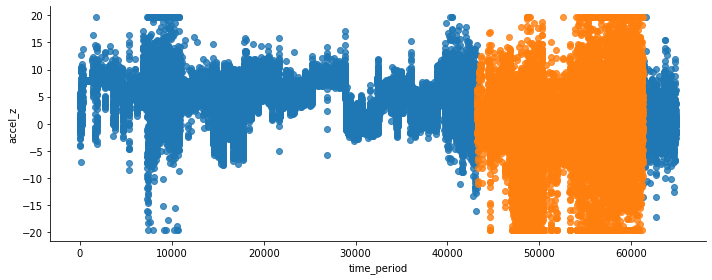

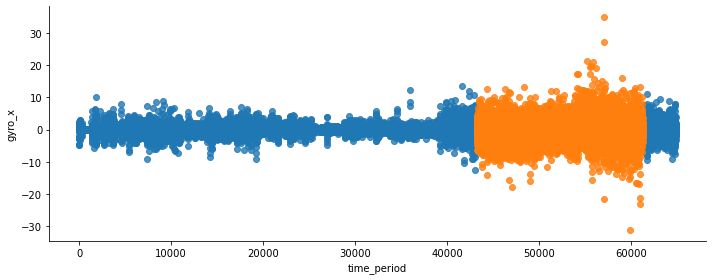

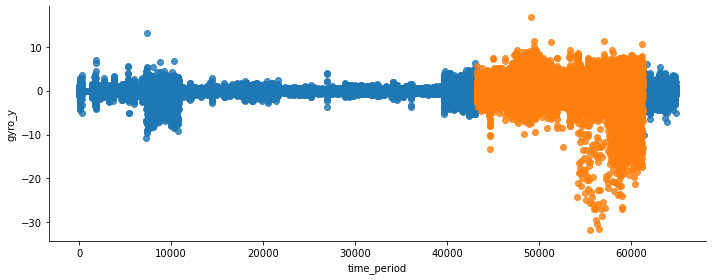

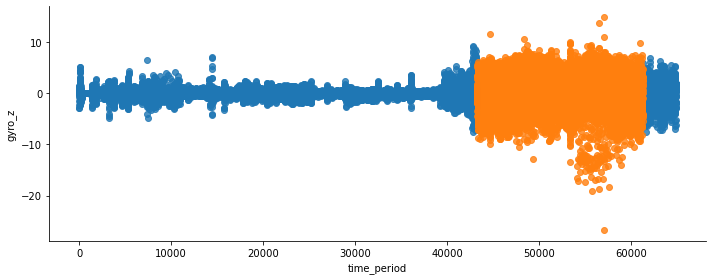

In [68]:
# Notes:
# It takes too much real estate to plot all the subjects. But flipping through them with the random shuffle above,
# there appears to be some patterns. The accelerometer measures high values maxing at 20 and minning at -20 
# during exercise periods, and may be reflected in some sort of variance/volatility measure.
# The gyro does the same but not as consistently throughout the exercise period-- this may be reflective of
# different activities, e.g. running vs kicking. 

# We may be able to mix time-series & machine learning techniques here. E.g. columns for +10, +20, +30 etc.
# time period forecast as features. Self-exciting threshold auto-regressive models, GARCH or similar could be useful.
# But we need to also think about speed. Fitting a time series for each training data point is a lot of iterations.

# Alternative is to use these time-series models as inspiration, but approach it from a curve fitting perspective,
# no autoregressive or moving average component.
x_variables = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
multi_scatter_plot(data, x_variables=x_variables, y_variable='is_exercise', subject_id=subject_ids[0])

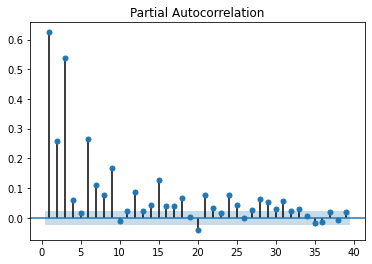

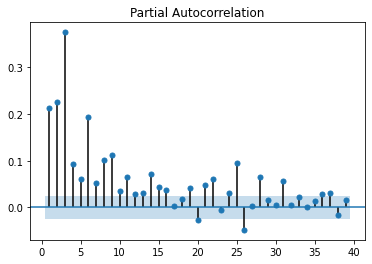

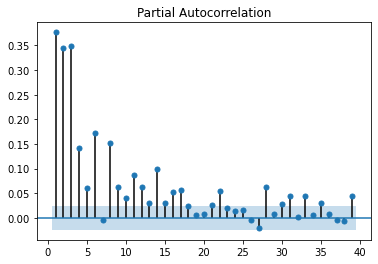

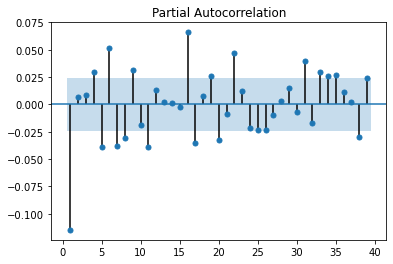

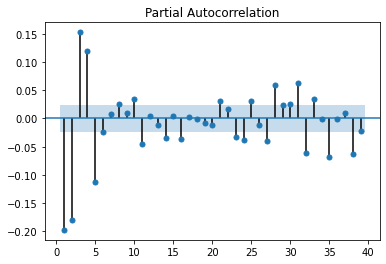

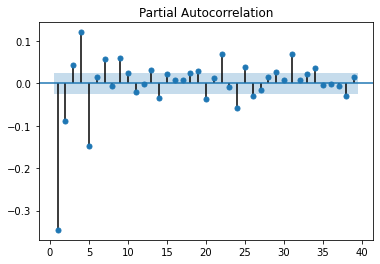

In [81]:
# Pretty expected, but we're seeing very significant partial autocorrelations.

# Reminder: PACF works by fitting a regression of xt-k values. Then it outputs xt_hat and xt-k_hat. Subract
# xt and xt-k by their fitted values, then output their covariance. The idea is to explain away any
# internal autocorrelation that is being picked up, e.g. xt and xt-k may appear correlated simply because they
# are both correlated to xt-k-n.

x_variables = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
pacf_plots(data, x_variables=x_variables, y_variable='is_exercise', 
           subject_id=subject_ids[0], downsample_steps=10)